# Predicting Mineral Hardness: A Regression Approach on the Mohs Scale 

### Luke Flannigan

# Project Summary

In this project, I developed a machine learning model to predict the Mohs hardness of minerals, a measure of scratch resistance, as part of a [Kaggle](https://www.kaggle.com/competitions/playground-series-s3e25) competition. The goal was to create a regression model with predictions evaluated based on Median Absolute Error (MedAE) against actual hardness values.
The dataset, sourced from Kaggle, was preprocessed by removing duplicates and rows with zero values in features but non-zero in hardness. An extensive Exploratory Data Analysis (EDA) was conducted, focusing on the distribution of the target variable, feature distributions, correlation analysis, and feature-target relationships. This analysis informed the feature selection process, leading to the removal of certain features displaying multicolinearity such as 'allelectrons_Average'.

For the modeling phase, a range of tree-based regression models, including RandomForest, CatBoost, LGBM, and XGBoost, were initially explored. LightGBM emerged as the top performer in base model evaluations, particularly when using Mean Absolute Error (MAE) as the objective function, which significantly boosted MedAE scores.

Further refinement was achieved through Optuna for hyperparameter tuning of the top-performing models. Although a stacked ensemble model was created, using these optimized models as base learners and linear regression as the meta-model, the Optuna-tuned LightGBM model ultimately proved to be the most effective, likely due to its alignment with the MedAE owing to the use of MAE as the objective function.

The project demonstrates the application of machine learning techniques to a practical problem, achieving a significant improvement in predicting mineral hardness with a data-driven and methodical approach.

# Problem Statement
This project aims to develop a machine learning model to predict the Mohs hardness of minerals based on their physical and chemical properties. 

### Benchmark
The primary benchmark for model evaluation is Median Absolute Error (MedAE), chosen for its relevance in the Kaggle competition as a direct measure of the median deviation of predicted values from actual hardness values.

### Data Origin and Characteristics
The data for this project is sourced from [Kaggle](https://www.kaggle.com/competitions/playground-series-s3e25/data). It includes two main files: `train.csv` and `test.csv`, synthesized from an original dataset on Mohs hardness through a deep learning model. The dataset contains continuous features describing each mineral's physical and chemical attributes. 

### Informal Success Measures
In addition to MedAE, informal success measures include the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²).

### Project Goals
The goal of this project is not only to construct an effective model for predicting mineral hardness but also to enhance understanding and application of machine learning techniques in a real-world context. Through this project, I aim to gain deeper insights into data science and its practical uses in solving complex problems.

# Dataset Overview
The data for this challenge comprises three main files:
- `train.csv`: Contains data for training the model, including various properties of minerals and their Mohs hardness.
- `test.csv`: Features similar data but without hardness values. The predictions made on this dataset will be submitted to Kaggle for scoring against the actual values.

- `original_data.csv`: The original dataset used by the deep learning model to generate the train and test datasets for kaggle. It contains a complete set of features including the target Hardness, matching the train.csv file.

Each row in these datasets represents a mineral and includes 12 features for the test set and 13 for the training set (including the target variable `Hardness`).

## Features Description
The dataset describes each mineral with the following attributes:
- `id`: A unique identifier for each mineral sample. Not useful for predicting hardness.
- `allelectrons_Total`: Total electrons in elements of the mineral.
- `density_Total`: Overall density of the mineral.
- `allelectrons_Average`: Average electrons of elements.
- `val_e_Average`: Average number of valence electrons.
- `atomicweight_Average`: Average atomic weight of the mineral's elements.
- `ionenergy_Average`: Average ionization energy.
- `el_neg_chi_Average`: Average electronegativity.
- `R_vdw_element_Average`: Average van der Waals radius.
- `R_cov_element_Average`: Average covalent radius.
- `zaratio_Average`: Average atomic number ratio.
- `density_Average`: Average density.
- `Hardness`: The Mohs hardness of the mineral, which is the target variable for the training set.

## Dataset Scale
- The training dataset contains 10,407 entries.
- The test dataset includes 6,939 entries.

## Data Processing Tools and Steps
For data processing, the following tools and steps were employed:

- **Concatenation**: The train dataset was concatenated with the original Mohs hardness dataset to enrich the training data.
- **Duplicate Removal**: Duplicates in the dataset were identified and removed to ensure the uniqueness of each data point.
- **Cleaning Zero-Value Rows**: Rows with zero values for all features but non-zero values for Mohs hardness were dropped. 
- **Minimal Processing**: Overall, not much processing was required as the data was already in a clean and well-structured format. This aspect allowed for a more straightforward approach in model development and evaluation.

## Importing Necessary Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

# Evaluation Metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error, r2_score
from numpy import sqrt

# Hyperparameter optimization
import optuna

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset
As part of loading the datasets it was decided to concatonate the train.csv file and the original_data.csv file. In my own experimentation this approach has shown to improve model performance, likely due to the more diverse dataset enhancing the model's ability to learn.

In [2]:
# Loading the datasets
train = pd.read_csv('./mohs_data/train.csv')
test = pd.read_csv('./mohs_data/test.csv')

# drop id not needed
train= train.drop(['id'], axis=1)
test = test.drop(['id'], axis=1)

# Loading original dataset
original_data = pd.read_csv('./mohs_data/original_data.csv')

original_data = original_data.drop(original_data.columns[0], axis=1)

# concatonating the train dataset with the original dataset
train = pd.concat([original_data, train])

train.reset_index(drop=True, inplace=True)

## Initial Data Exploration
In this section, the dataset is explored to gain an initial understanding and prepare for more in-depth analysis. The steps include:

- Displaying the first few rows of the training and testing datasets.
- Reviewing data types in the training dataset.
- Examining statistical summaries of the training dataset's features.
- Checking the number of rows and columns in both datasets.
- Identifying the number of unique values in each feature of the training dataset.
- Assessing if there are missing values in the training dataset.

In [3]:
train.head(10)

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,2.3,110.0,23.000000,36.666667,2.666667,82.598467,8.504133,2.146667,2.006667,1.253333,0.456803,7.666667
1,5.5,406.0,30.472136,9.902439,4.682927,19.813180,11.456151,2.700244,1.676829,0.868293,0.522909,0.743223
2,5.5,406.0,30.472464,10.410256,4.923077,20.931371,11.541405,2.753590,1.703846,0.894359,0.497498,0.781345
3,5.5,476.0,61.142135,11.609756,4.682927,23.659644,11.487395,2.763659,1.714634,0.848780,0.519474,1.491272
4,5.5,476.0,61.142464,12.205128,4.923077,24.975089,11.574251,2.820256,1.743590,0.873846,0.493887,1.567755
5,6.0,113.0,13.512992,11.300000,4.700000,23.099695,11.105350,2.720000,1.763000,0.896000,0.494111,1.351299
6,5.5,136.0,9.509324,11.333333,4.666667,22.718434,10.958558,2.599167,1.765833,0.970000,0.499074,0.792444
7,3.8,41.0,9.440000,20.500000,4.000000,43.498522,8.897000,2.065000,1.925000,1.165000,0.477015,4.720000
8,6.3,130.0,10.670656,10.000000,4.923077,20.170427,11.117292,2.750769,1.736154,0.875385,0.496606,0.820820
9,5.8,226.0,20.680400,10.761905,4.761905,21.725227,11.485876,2.764762,1.698095,0.858095,0.520631,0.984781


In [4]:
test.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11029 entries, 0 to 11028
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hardness               11029 non-null  float64
 1   allelectrons_Total     11029 non-null  float64
 2   density_Total          11029 non-null  float64
 3   allelectrons_Average   11029 non-null  float64
 4   val_e_Average          11029 non-null  float64
 5   atomicweight_Average   11029 non-null  float64
 6   ionenergy_Average      11029 non-null  float64
 7   el_neg_chi_Average     11029 non-null  float64
 8   R_vdw_element_Average  11029 non-null  float64
 9   R_cov_element_Average  11029 non-null  float64
 10  zaratio_Average        11029 non-null  float64
 11  density_Average        11029 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


In [6]:
train.describe()

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
count,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000,11029.000000
mean,4.645257,138.478018,15.245564,16.907728,4.539603,37.210823,10.947921,2.608727,1.727907,0.940243,0.494563,2.121260
std,1.683270,300.368288,18.357166,10.453091,0.698567,25.961319,1.430073,0.339107,0.197129,0.181762,0.065491,1.937599
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,68.000000,7.558488,10.000000,4.000000,20.298893,10.599905,2.530000,1.672500,0.864000,0.476196,0.812440
50%,5.500000,100.000000,11.073072,12.500000,4.700000,26.164726,11.221459,2.706000,1.732000,0.914286,0.489272,1.345930
75%,6.000000,138.000000,17.590000,21.833333,4.800000,48.719500,11.688350,2.805000,1.797813,0.980000,0.496606,2.732000
max,10.000000,15300.000000,643.093804,67.000000,6.000000,167.400000,15.245810,3.443000,2.250000,1.615840,0.825990,10.970000


In [7]:
print(train.shape)
print(test.shape)

(11029, 12)
(6939, 11)


In [8]:
train.nunique()

Hardness                   50
allelectrons_Total        366
density_Total            1180
allelectrons_Average      727
val_e_Average             247
atomicweight_Average      954
ionenergy_Average         995
el_neg_chi_Average        863
R_vdw_element_Average     824
R_cov_element_Average     779
zaratio_Average           922
density_Average          1120
dtype: int64

Only 50 unique values for Hardness. Not a true continuous variable. 

In [9]:
train.isna().sum()

Hardness                 0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
dtype: int64

Upon examination it is clear that the dataset contains no null values.

# Exploratory Data Analysis
Here a more in depth analysis of the dataset was conducted. 

### Graphs Used and Their Justifications
1.  **Histogram of the Target Variable (Mohs Hardness):** To visualize the distribution of the Mohs hardness values in the dataset.
2.  **Histograms and Box Plots for Features:** These were used to help understand the spread and range of values for each feature, highlighting any outliers or unusual distributions.
3.  **Correlation Matrix:** A matrix to visualize the correlation coefficients between all features and the target variable. This helps in identifying potential linear relationships and redundant features.
4.  **Pairplot:** To explore possible non-linear relationships between features and the target variable, beyond what can be inferred from linear correlations.
5.  **Analysis of High Correlation Pairs:** Focusing on pairs of features with high correlation to understand their relationships in more detail as well as explore multicollinearity.

### Data Wrangling
- **Feature Set Experimentation**: Explored different feature subsets, ultimately dropping some based on their performance impact/multicolinearity.
- **Feature Combination and Outlier Handling**: Attempts to create new feature combinations and handle outliers did not yield significant improvements.

### Modeling Approach
- **No Feature Normalization**: Chose not to normalize features, aligning with the modeling strategy.
- **Use of Tree-Based Models**: Opted for tree-based models like Random Forest due to:
  - Complex relationships in data without clear linear patterns.
  - Presence of outliers and data skewness, where tree-based models excel due to their robustness.

### Target Variable Analysis: Distribution of Mohs Hardness
The histogram below visualizes the distribution of Mohs hardness in the dataset.

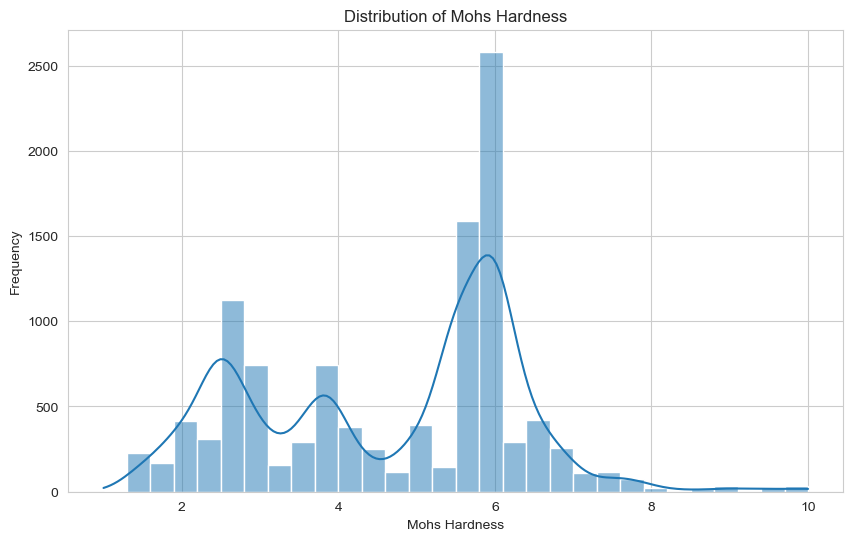

In [229]:
sns.set_style("whitegrid")

# Histogram of the target variable 'Hardness'
plt.figure(figsize=(10, 6))
sns.histplot(train['Hardness'], kde=True, bins=30)
plt.title('Distribution of Mohs Hardness')
plt.xlabel('Mohs Hardness')
plt.ylabel('Frequency')
plt.show()

### Analysis of Mohs Hardness Distribution
The distribution of Mohs hardness values exhibits noticeable concentrations around hardness levels 2, 4, and especially 6, indicating a relatively higher representation of minerals with these specific values in the dataset.

### Examining Distributions and Outliers for Each Feature
The dataset's features are explored through histograms and box plots. Histograms show the spread of values for each feature, and box plots provide a clear view of their range, including any outliers. This analysis will help identify features with extreme values that might require special attention during preprocessing.

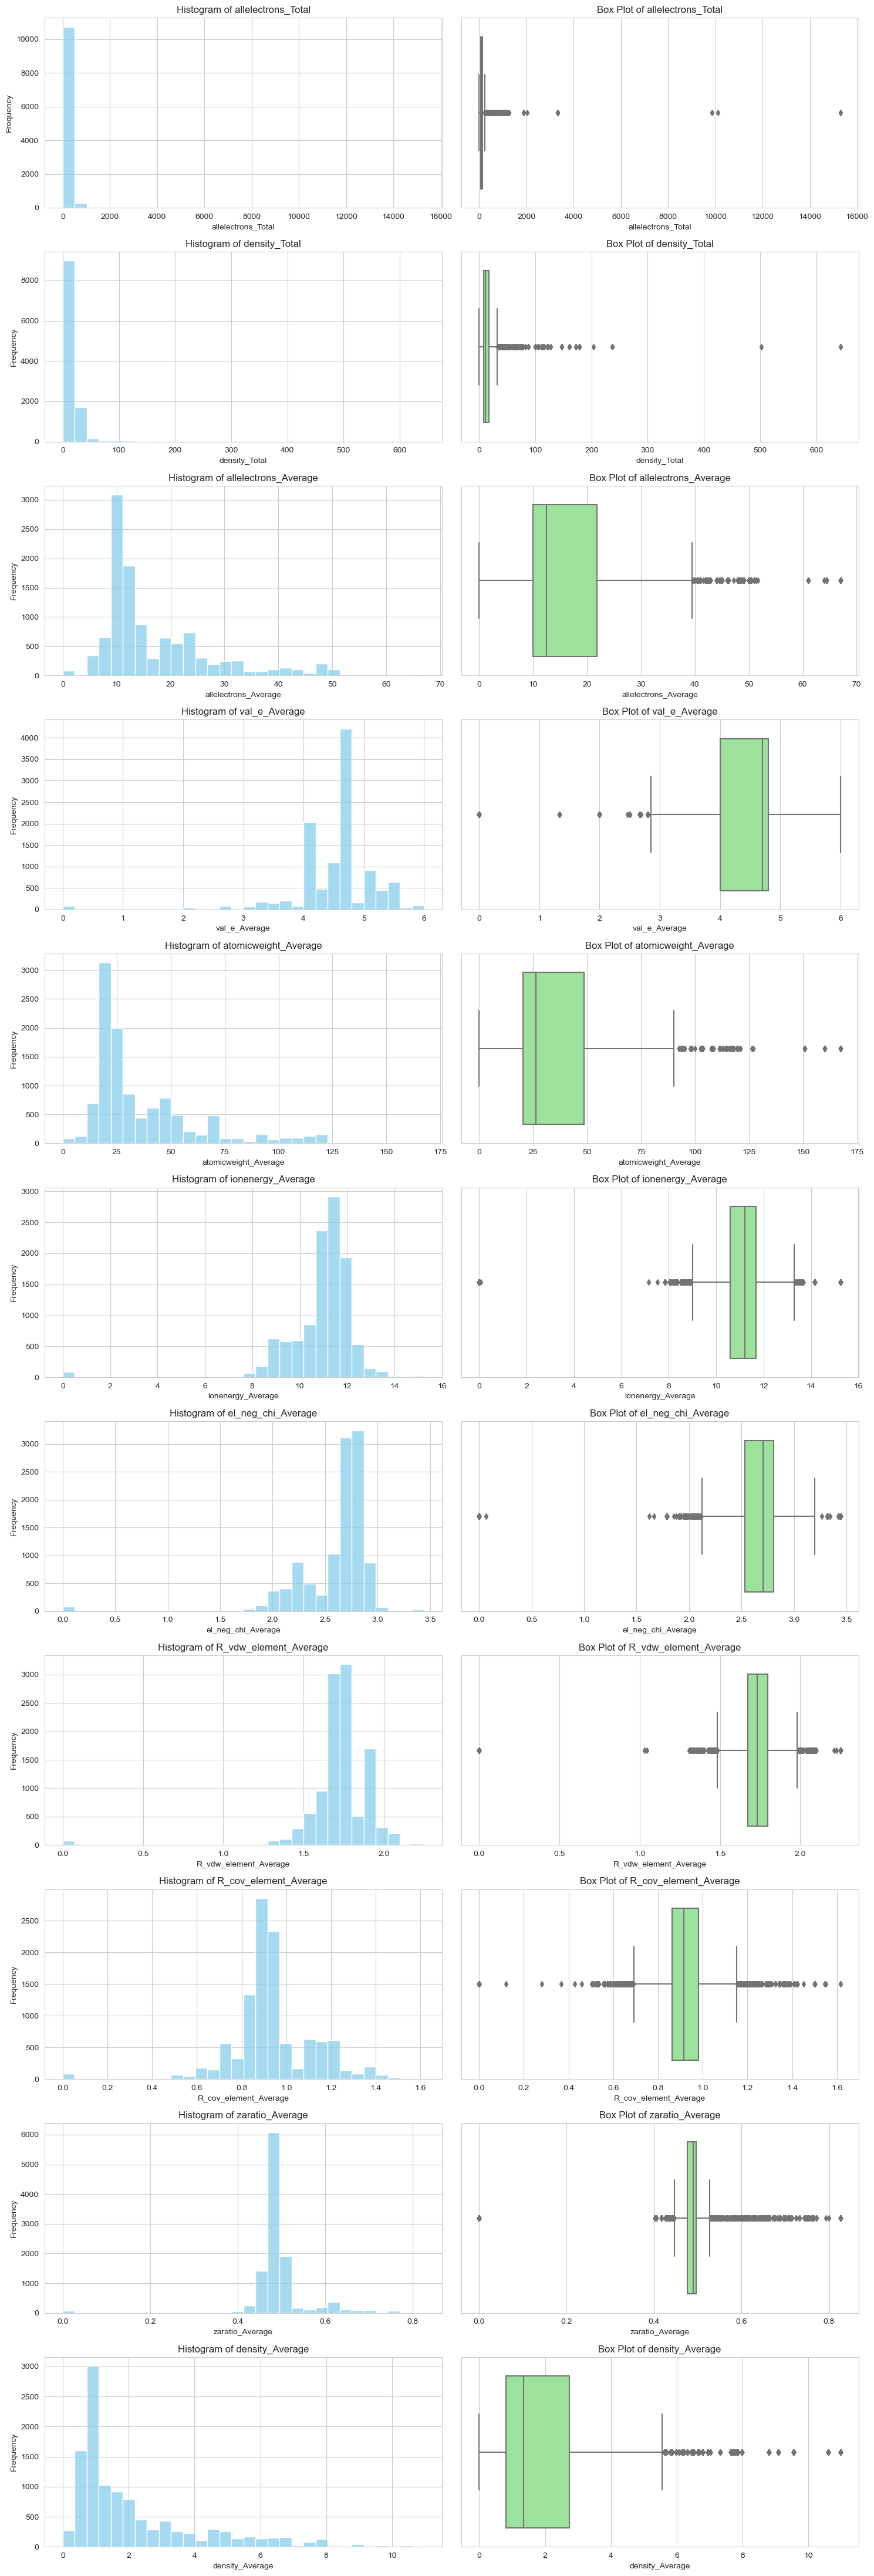

In [230]:
features = train.columns.drop('Hardness')

# Grid of Histograms and Box Plots for each feature
fig, axes = plt.subplots(len(features), 2, figsize=(15, 4 * len(features)))
for i, feature in enumerate(features):
    # Histogram
    sns.histplot(train[feature], ax=axes[i, 0], kde=False, color='skyblue', bins=30)
    axes[i, 0].set_title(f'Histogram of {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Frequency')

    # Box Plot
    sns.boxplot(x=train[feature], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'Box Plot of {feature}')
    axes[i, 1].set_xlabel(feature)

plt.tight_layout()
plt.show()

### Analysis of Feature Distributions and Outliers
The grid of histograms and box plots for each feature reveals two key observations:

- **Outliers**: Several features display a significant number of outliers, as indicated by the box plots. Notably, `allelectrons_Total` stands out with a few exceptionally extreme outliers.

- **Skewed Distributions**: A number of features display a left-skewed distribution in their histograms. 

### Correlation Matrix of Features
To understand how different features are related to each other and to the target variable, a correlation matrix is presented. This matrix is important for identifying features that have strong relationships with Mohs hardness, which can be useful in predicting it.

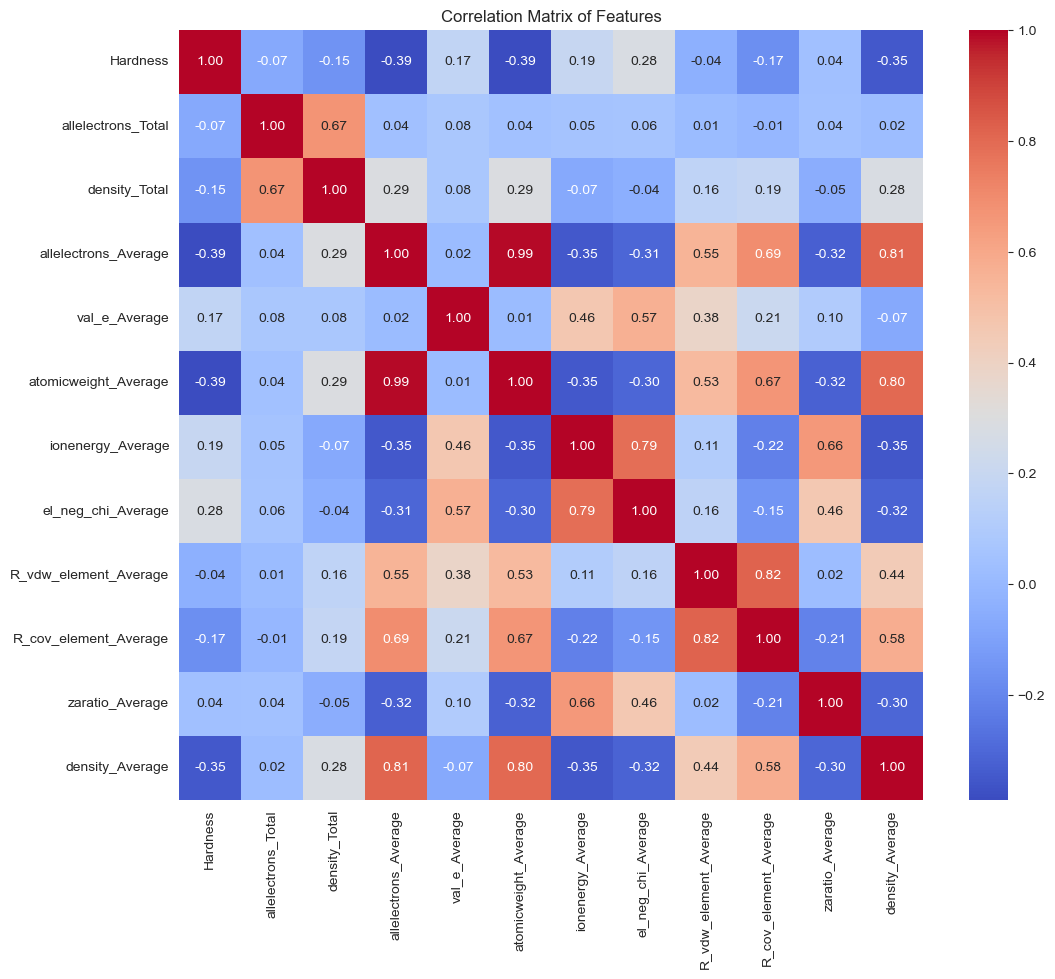

In [231]:
plt.figure(figsize=(12, 10))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

### Insights from the Correlation Matrix
- **High Correlations Among Features**: 
  - An exceptionally high correlation of 0.99 between `allelectrons_Average` and `atomicweight_Average` suggests a near duplication of information, indicating redundancy.
  - Additionally, `density_Average` shows significant correlations (around 0.8) with both `allelectrons_Average` and `atomicweight_Average`. This further points to overlapping information provided by these features.
- **Correlation with Mohs Hardness**: The dataset reveals a lack of strong linear correlation between the features and the Mohs hardness. This suggests that the relationship between the features and the target variable is complex and not linearly dependent.

Tree-based models could be effective here b/c complex feature relationships and multicolinearity. 

### Exploring Feature-Target Relationships
To uncover potential non-linear relationships between features and Mohs hardness a pairplot is used, offering visual insights beyond linear correlations.

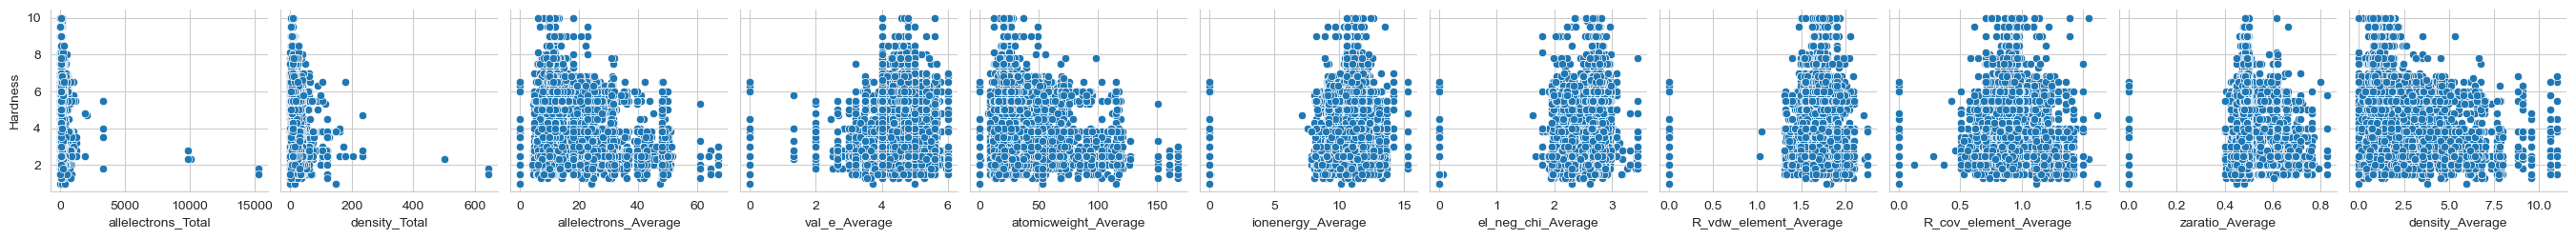

In [232]:
features = train.columns.drop('Hardness')
sns.pairplot(train, x_vars=features, y_vars='Hardness',)
plt.show()

### Findings from Pairplot
The pairwise plots did not reveal any distinct non-linear relationships between the features and the target variable, Mohs hardness. These visualizations confirm the earlier inference from the correlation matrix, suggesting that the relationship between features and the target is subtle and may not be captured through simple linear or non-linear visual methods.

### Analyzing High Correlation Pairs Among Features
In this section, the focus is on pairs of features that exhibit high correlation, as identified in the correlation matrix. This analysis aims to explore these specific relationships in more detail, understanding how certain features might mirror or influence each other in order to better address potential multicolinearity issues in the modeling phase. 

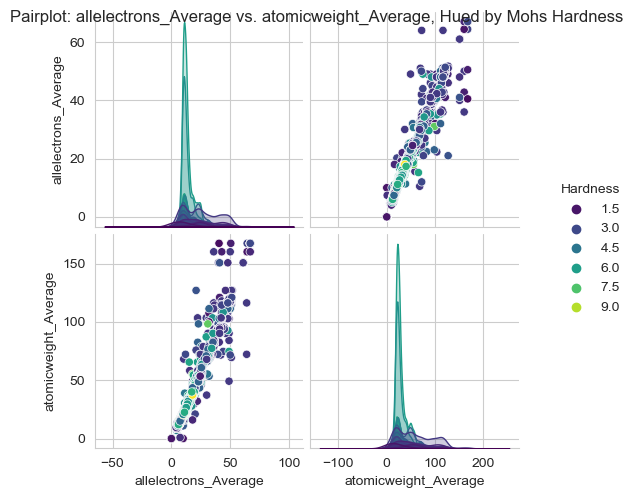

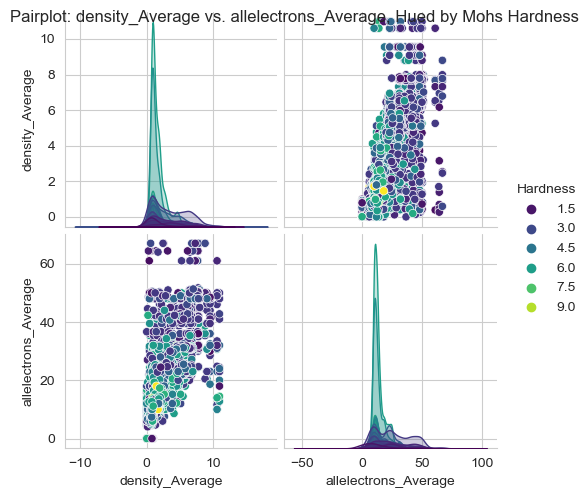

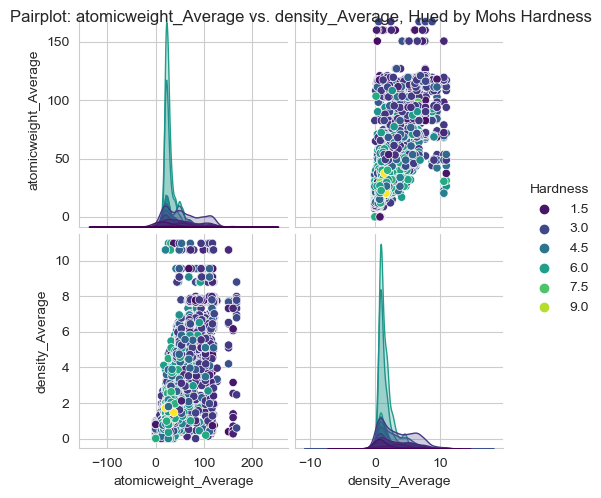

In [233]:
# highly correlated features
feature_pairs = [
    ('allelectrons_Average', 'atomicweight_Average'),
    ('density_Average', 'allelectrons_Average'),
    ('atomicweight_Average', 'density_Average')
]

# Create pairplots for each pair
for pair in feature_pairs:
    sns.pairplot(train, vars=pair, hue='Hardness', palette='viridis')
    plt.suptitle(f'Pairplot: {pair[0]} vs. {pair[1]}, Hued by Mohs Hardness')
    plt.show()

# Data Preprocessing

### Feature Removal, Scaling Considerations, and Data Cleaning:

1.  **Feature Removal:**
    -   Examined features with high multicollinearity for removal. This was done to reduce the complexity of the model and improve its interpretability.
    -   Decision to drop certain features was based on their lack of impact on predicting Mohs hardness (from feature importance data) and their high correlation with other features.
2.  **Scaling:**
    -   Scaling was not initially considered, given the focus on tree-based models which are generally less sensitive to the scale of features.

3.  **Data Cleaning:**
    -  Rows with 0 values for features but values for Mohs hardness were removed.
    -  Duplicates in dataset were removed. 

**Considered but Not Used:**

1.  **Aggressive Outlier Removal:**
    -   Initially tried removing outliers completely but found that this approach excessively reduced the dataset size, leading to overfitting in training and poor performance on the test set.
    -   This method was abandoned in favor of a less drastic approach to handling outliers.
2.  **Clipping Outliers:**
    -   A milder method of managing outliers by clipping their values was also experimented with. However, this approach did not yield improvements in model performance.
    -   The lack of positive impact led to the decision not to incorporate this method into the final preprocessing strategy. 

### Feature Redundancy Reduction
Allelectrons_Average was dropped for its lower impact in predicting Mohs hardness.

In [10]:
features_to_drop = ['allelectrons_Average']  
train = train.drop(features_to_drop, axis=1)

test = test.drop(features_to_drop, axis=1)

train.head()

,Hardness,allelectrons_Total,density_Total,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,2.3,110.0,23.000000,2.666667,82.598467,8.504133,2.146667,2.006667,1.253333,0.456803,7.666667
1,5.5,406.0,30.472136,4.682927,19.813180,11.456151,2.700244,1.676829,0.868293,0.522909,0.743223
2,5.5,406.0,30.472464,4.923077,20.931371,11.541405,2.753590,1.703846,0.894359,0.497498,0.781345
3,5.5,476.0,61.142135,4.682927,23.659644,11.487395,2.763659,1.714634,0.848780,0.519474,1.491272
4,5.5,476.0,61.142464,4.923077,24.975089,11.574251,2.820256,1.743590,0.873846,0.493887,1.567755


### Further Data Cleaning
- Remove duplicates in dataset.
- Filter rows with non-zero features.

In [11]:
features = train.columns.drop('Hardness')

duplicates = train.duplicated()
print(duplicates.any()) 

train.drop_duplicates(inplace=True)

train = train[train[features].any(axis=1)]

train.reset_index(drop=True)

True


,Hardness,allelectrons_Total,density_Total,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,2.3,110.0,23.000000,2.666667,82.598467,8.504133,2.146667,2.006667,1.253333,0.456803,7.666667
1,5.5,406.0,30.472136,4.682927,19.813180,11.456151,2.700244,1.676829,0.868293,0.522909,0.743223
2,5.5,406.0,30.472464,4.923077,20.931371,11.541405,2.753590,1.703846,0.894359,0.497498,0.781345
3,5.5,476.0,61.142135,4.682927,23.659644,11.487395,2.763659,1.714634,0.848780,0.519474,1.491272
4,5.5,476.0,61.142464,4.923077,24.975089,11.574251,2.820256,1.743590,0.873846,0.493887,1.567755
...,...,...,...,...,...,...,...,...,...,...,...
10992,4.0,128.0,7.558488,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.796070
10993,5.0,30.0,1.743160,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.814800
10994,1.8,196.0,30.920000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.115400
10995,6.0,38.0,1.553160,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.777550


# Machine Learning Approaches
   
**Baseline Model Explanation:**

The baseline models for this project included RandomForestRegressor, CatBoostRegressor, LGBMRegressor, XGBoostRegressor, and Linear Regression (quicky removed due to significantly worse performance). These were chosen to provide a comprehensive initial assessment across a range of regression techniques, from simple to more complex and robust methods. K-fold cross validation was used to analyze the models' ability to generalize to data and increase the reliability of performance metrics. 

**Family of Machine Learning Algorithms and Rationale:**

-   The primary family of machine learning algorithms used is tree-based models. This choice is due to their effectiveness in handling datasets with complex relationships and high multicollinearity, common in regression tasks involving physical and chemical properties like in this project.

### Example Performance
- **RandomForest**: Achieved a Median Absolute Error (MedAE) of 0.63.

### Improvement Model
- **Optuna-tuned LGBM**: Light Gradient Boosting Machine (LGBM) model fine-tuned using the Optuna framework reduced the MedAE to 0.51.


### Dataset Splitting

In [237]:
X = train.drop(['Hardness'], axis=1)
y = train['Hardness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Base Model Testing

### RandomForestRegressor

In [238]:
rf_model = RandomForestRegressor()
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_median_absolute_error')
rf_medae_cv = -rf_cv_scores.mean()
print(f"Median Absolute Error (CV) for RandomForestRegressor: {rf_medae_cv}")

# Fit the model and make predictions
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_importances = rf_model.feature_importances_

# Evaluate metrics
medae_rf = median_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Median Absolute Error for RandomForestRegressor: {medae_rf}")
print(f"Mean Squared Error for RandomForestRegressor: {mse_rf}")
print(f"Root Mean Squared Error for RandomForestRegressor: {rmse_rf}")
print(f"R-squared for RandomForestRegressor: {r2_rf}")

Median Absolute Error (CV) for RandomForestRegressor: 0.6319333333333315
Median Absolute Error for RandomForestRegressor: 0.6049999999999995
Mean Squared Error for RandomForestRegressor: 1.539705145208459
Root Mean Squared Error for RandomForestRegressor: 1.2408485585309994
R-squared for RandomForestRegressor: 0.4433560725164335


### XGBRegressor

In [239]:
xgb_model = XGBRegressor()
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_median_absolute_error')
medae_xgb_cv = -xgb_cv_scores.mean()
print(f"Median Absolute Error (CV) for XGBoost: {medae_xgb_cv}")

# Fit the model and make predictions
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_importances = xgb_model.feature_importances_

# Evaluate metrics
medae_xgb = median_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print(f"Median Absolute Error for XGBoost: {medae_xgb}")
print(f"Mean Squared Error for XGBoost: {mse_xgb}")
print(f"Root Mean Squared Error for XGBoost: {rmse_xgb}")
print(f"R-squared for XGBoost: {r2_xgb}")

Median Absolute Error (CV) for XGBoost: 0.6453879547119141
Median Absolute Error for XGBoost: 0.6430493831634521
Mean Squared Error for XGBoost: 1.6158998925715489
Root Mean Squared Error for XGBoost: 1.2711805114032975
R-squared for XGBoost: 0.41580966627248594


### LGBMRegressor

In [240]:
lgbm_model = LGBMRegressor(objective='mae')
lgbm_cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='neg_median_absolute_error')
lgbm_medae_cv = -lgbm_cv_scores.mean()
print(f"Median Absolute Error (CV) for LightGBM: {lgbm_medae_cv}")

# Fit the model and make predictions
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
lgbm_importances = lgbm_model.feature_importances_

# Evaluate metrics
medae_lgbm = median_absolute_error(y_test, y_pred)
mse_lgbm = mean_squared_error(y_test, y_pred)
rmse_lgbm = sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Median Absolute Error for LightGBM: {medae_lgbm}")
print(f"Mean Squared Error for LightGBM: {mse_lgbm}")
print(f"Root Mean Squared Error for LightGBM: {rmse_lgbm}")
print(f"R-squared for LightGBM: {r2_lgbm}")

Median Absolute Error (CV) for LightGBM: 0.5160180175627487
Median Absolute Error for LightGBM: 0.5319423604681459
Mean Squared Error for LightGBM: 1.54264158303509
Root Mean Squared Error for LightGBM: 1.2420312327132075
R-squared for LightGBM: 0.44229447296945923


Notably, using the MAE for the objective function significantly boosted MedAE score. But this focus might have made the model a bit less accurate overall, as seen from the higher MSE and lower R-squared score compared to no MAE objective. Still it is good for Kaggle leaderboard which is what I am mainly focusing on.

### CatBoostRegressor

In [241]:
catboost_model = CatBoostRegressor(verbose=0)
catboost_cv_scores = cross_val_score(catboost_model, X_train, y_train, cv=5, scoring='neg_median_absolute_error')
catboost_medae_cv = -catboost_cv_scores.mean()
print(f"Median Absolute Error (CV) for CatBoost: {catboost_medae_cv}")

# Fit the model and make predictions
catboost_model.fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)
catboost_importances = catboost_model.get_feature_importance()

# Evaluate metrics 
medae_catboost = median_absolute_error(y_test, y_pred)
mse_catboost = mean_squared_error(y_test, y_pred)
rmse_catboost = sqrt(mse_catboost)
r2_catboost = r2_score(y_test, y_pred)

# Print the evaluation metrics 
print(f"Median Absolute Error for CatBoost: {medae_catboost}")
print(f"Mean Squared Error for CatBoost: {mse_catboost}")
print(f"Root Mean Squared Error for CatBoost: {rmse_catboost}")
print(f"R-squared for CatBoost: {r2_catboost}")

Median Absolute Error (CV) for CatBoost: 0.6443155291518579
Median Absolute Error for CatBoost: 0.6447617964480967
Mean Squared Error for CatBoost: 1.4746265994397343
Root Mean Squared Error for CatBoost: 1.2143420438409165
R-squared for CatBoost: 0.46688367936009145


## Aggregated Feature Importance Analysis

Consolidating feature importance from RandomForest, XGBoost, LightGBM, and CatBoost to identify consistently influential features.

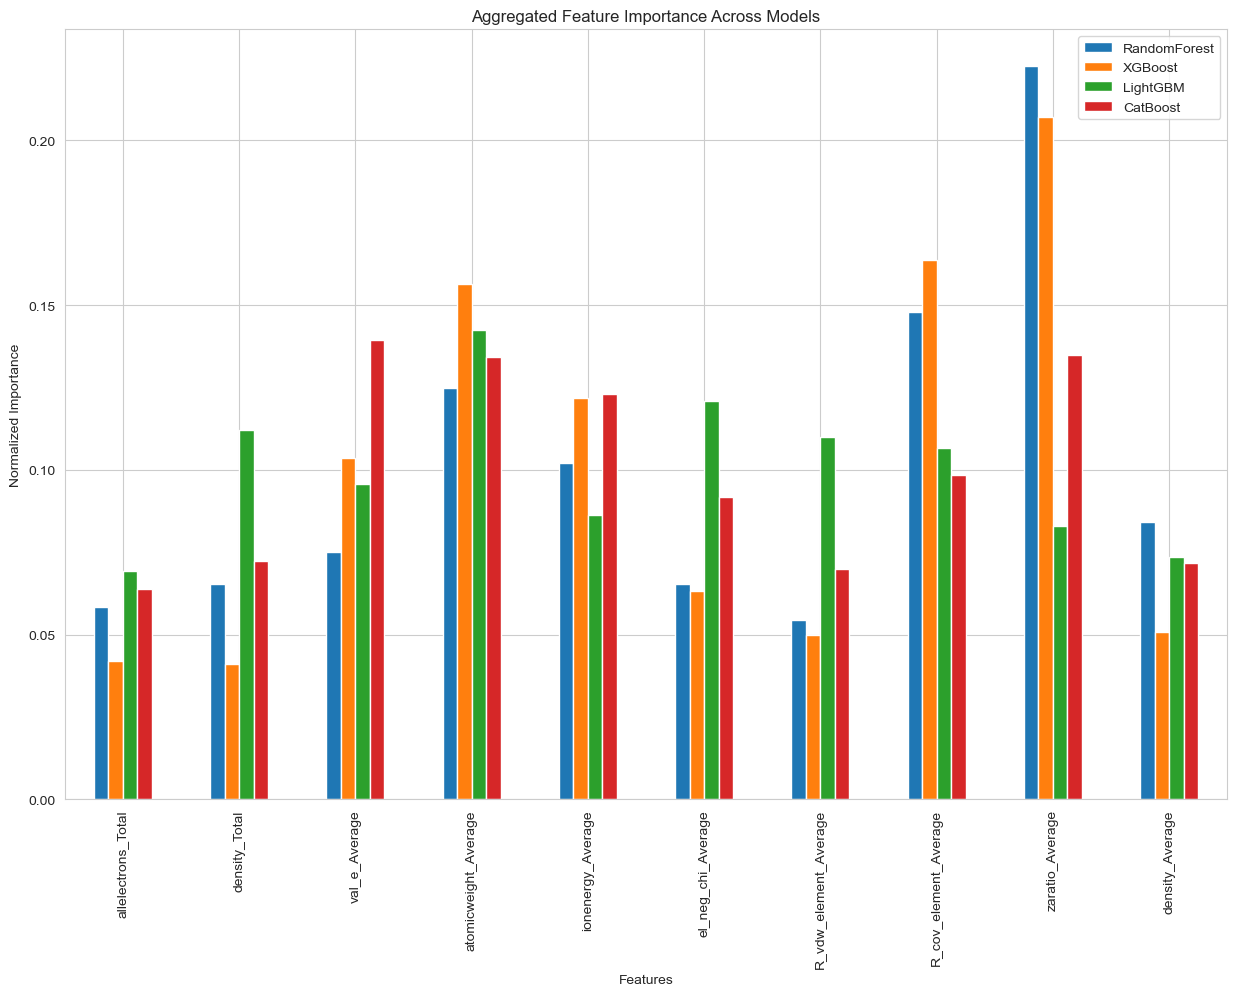

In [242]:
# Create a DataFrame to hold all importances
feature_importance_df = pd.DataFrame({
    'RandomForest': rf_importances,
    'XGBoost': xgb_importances,
    'LightGBM': lgbm_importances,
    'CatBoost': catboost_importances
}, index=X_train.columns)

# Normalize the importance data
feature_importance_df_normalized = feature_importance_df / feature_importance_df.sum()

# Plotting the aggregated feature importances
plt.figure(figsize=(15, 10))
feature_importance_df_normalized.plot(kind='bar', ax=plt.gca())
plt.title('Aggregated Feature Importance Across Models')
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.show()

### Model Performance Ranking

In [243]:
model_medae_scores = {
    'RandomForestRegressor': {'CV MedAE': rf_medae_cv, 'Test MedAE': medae_rf},
    'XGBoost': {'CV MedAE': xgb_medae_cv, 'Test MedAE': medae_xgb},
    'LightGBM': {'CV MedAE': lgbm_medae_cv, 'Test MedAE': medae_lgbm},
    'CatBoost': {'CV MedAE': catboost_medae_cv, 'Test MedAE': medae_catboost}
}

print("Model Performance (Median Absolute Error):")
for model, scores in model_medae_scores.items():
    print(f"{model}: CV MedAE = {scores['CV MedAE']:.4f}, Test MedAE = {scores['Test MedAE']:.4f}")

Model Performance (Median Absolute Error):
RandomForestRegressor: CV MedAE = 0.6319, Test MedAE = 0.6050
XGBoost: CV MedAE = 0.6454, Test MedAE = 0.6430
LightGBM: CV MedAE = 0.5160, Test MedAE = 0.5319
CatBoost: CV MedAE = 0.6443, Test MedAE = 0.6448


### Baseline Model Performance Summary

LightGBM clearly appears as the top performer in the base models judging strictly on MedAE as the Kaggle compeition is doing. Using MAE as the objective function had a big effect on improving MedAE scores. 

## Hyperparameter Tuning with Optuna

After establishing baseline models, I am now focusing on hyperparameter tuning to optimize RandomForestRegressor, LightGBMRegressor, and XGBRegressor. I plan to use Optuna to accomplish this. 

### Selected Approach:
- **Model Selection**: RandomForestRegressor, LightGBM, and XGBoost are chosen based on initial performance metrics.
- **Simplified Tuning**: Originally I was quite lost trying to learn how to use Optuna and determine what the best hyperparameters choices were to include in the optimization study. I read basically every discussion/post on the Kaggle competition as well as documentation for models trying to understand the influence of each hyperparameter and its impact on the models performance. After reading all the posts, I initally tried to follow along similar to what others were doing. However, I don't feel I fully understood the purpose of each hyperparameter I was including, and so I have since simplified my parameter lists to focus in on the hyperparameters I understand and feel have the biggest impact in refining the models performance.
- **Cross-Validation Integration**: Incorporating K-Fold cross-validation ensures the models' stability and generalizability across the dataset.

### RandomForestRegressor Hyperparameter Tuning
- **`n_estimators`**: Adjusts the number of trees in the forest. 
- **`max_depth`**: Controls the depth of each tree. Deeper trees capture more complex patterns but might be overfitting.

In [244]:
# def objective_rf(trial):
#    params = {
#        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
#        'max_depth': trial.suggest_int('max_depth', 10, 30),
#    }
#    model = RandomForestRegressor(**params)
#    score = cross_val_score(model, X, y, cv=5, scoring='neg_median_absolute_error')
#    return -score.mean()

# study_rf = optuna.create_study(direction='minimize')
# study_rf.optimize(objective_rf, n_trials=30, show_progress_bar=True)
# print('Best parameters for RandomForestRegressor:', study_rf.best_params)

### LightGBM Hyperparameter Tuning
- **`num_leaves`**: Increases model complexity for better accuracy, but too many leaves can cause overfitting. 
- **`learning_rate`**: lower rate makes the model robust but slower to train.
- **`n_estimators`**: Boosting iterations

In [245]:
# def objective_lgb(trial):
#    params = {
#        'num_leaves': trial.suggest_int('num_leaves', 30, 100),  
#        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1), 
#        'n_estimators': trial.suggest_int('n_estimators', 100, 200),  
#        'objective': 'mae'
#    }
#    model = LGBMRegressor(**params)
#    score = cross_val_score(model, X, y, cv=5, scoring='neg_median_absolute_error')
#    return -score.mean()

# study_lgb = optuna.create_study(direction='minimize')
# study_lgb.optimize(objective_lgb, n_trials=30, show_progress_bar=True)
# print('Best parameters for LightGBM:', study_lgb.best_params)

### XGBoost Hyperparameter Tuning
- **`n_estimators`**: Boosting iterations.
- **`max_depth`**: Controls tree depth.
- **`learning_rate`**: lower rate makes the model robust but slower to train.

In [246]:
# def objective_xgb(trial):
#    params = {
#        'n_estimators': trial.suggest_int('n_estimators', 100, 200),  
#        'max_depth': trial.suggest_int('max_depth', 3, 10),  
#        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),  
#    }
#    model = XGBRegressor(**params)
#    score = cross_val_score(model, X, y, cv=5, scoring='neg_median_absolute_error')
#    return -score.mean()

# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)
# print('Best parameters for XGBoost:', study_xgb.best_params)

## Model Evaluation
Evaluating RandomForestRegressor, LightGBM, and XGBoost with optimized hyperparameters.

In [247]:
hyperparameters_rf = {
    'n_estimators': 176, 
    'max_depth': 16
}

hyperparameters_lgb = {
    'num_leaves': 98, 
    'learning_rate': 0.0772670192101047, 
    'n_estimators': 129,
    'objective': 'mae' 
}

hyperparameters_xgb = {
    'n_estimators': 200,
    'max_depth': 9,
    'learning_rate': 0.07340992031246413,
}

rf_model = RandomForestRegressor(**hyperparameters_rf)
lgbm_model = LGBMRegressor(**hyperparameters_lgb)
xgb_model = XGBRegressor(**hyperparameters_xgb)


rf_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_lgbm = lgbm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

medae_rf = median_absolute_error(y_test, y_pred_rf)
medae_lgbm = median_absolute_error(y_test, y_pred_lgbm)
medae_xgb = median_absolute_error(y_test, y_pred_xgb)

print(f"Random Forest: Median Absolute Error = {medae_rf}")
print(f"LightGBM: Median Absolute Error = {medae_lgbm}")
print(f"XGBoost: Median Absolute Error = {medae_xgb}")

Random Forest: Median Absolute Error = 0.6091380356441722
LightGBM: Median Absolute Error = 0.5107919807587947
XGBoost: Median Absolute Error = 0.6223773956298828


## Implementing Stacking Ensemble Model

To enhance predictive performance, I am expermienting with a Stacking Ensemble Model. This approach uses the strengths of the individually optimized RandomForest, LightGBM, and XGBoost models. By using these models as base learners and combining their predictions through a meta-learner (Linear Regression in this case), the stacked model will hopefully capture more complex patterns in the data. 

In [248]:
base_models = [
    ('rf', rf_model),
    ('lgbm', lgbm_model),
    ('xgb', xgb_model)
]

# Stacked Regressor
stacked_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5
)

# Fit the stacked model
stacked_regressor.fit(X_train, y_train)

# Evaluate the stacked model
stacked_predictions = stacked_regressor.predict(X_test)
stacked_medae = median_absolute_error(y_test, stacked_predictions)
print(f"Median Absolute Error for Stacked Model: {stacked_medae}")

Median Absolute Error for Stacked Model: 0.5828257179532661


## Opting for LightGBM model currently:
After some testing, the LightGBM model has emerged as the current best choice for predictions on the test set in the competition (gives best competition leaderboard score), outperforming the stacking ensemble model in Median Absolute Error (MedAE) score. 

Current score: .508

## Preparing Kaggle Submission

The final step is to generate predictions on the test dataset and prepare a submission file for Kaggle. This involves applying the model to the test data and formatting the predictions according to Kaggle's submission requirements. The predictions are then saved in a CSV file, ready for submission to the competition.

In [249]:
# Load the sample submission file 
sample_submission = pd.read_csv('./mohs_data/sample_submission.csv')

# Making predictions on the test set
predictions = lgbm_model.predict(test)

submission = sample_submission.copy()
submission['Hardness'] = predictions

# Save the submission file
submission.to_csv('submission.csv', index=False)

# Experiments

1.  **Data Concatenation:** Combined `train.csv` with the original dataset's train file, resulting in improved model performance.
2.  **Feature Dropping:** Experimented with removing features exhibiting high multicollinearity or negligible impact on model performance. Ultimately decided to drop allelectrons_Average based on feature importance data. 
3.  **Outlier Handling Attempts:**
    -   Initial approach involved aggressive removal of outliers, which led to overfitting due to a significant reduction in dataset size.
    -   A milder approach to managing outliers by clipping their values did not yield performance improvements.
4.  **Optuna Hyperparameter Tuning:** Conducted extensive experiments with Optuna for tuning hyperparameters of the models to optimize their performance.
5.  **Stacking Ensemble Model Creation:** Attempted to create a stacking ensemble model to leverage multiple individual models.
6.  **Using MAE as objective function for LGBM model:** This showed to singificantly improve my LGBM models MedAE score. It did not actually improve the models ability to generalize to new information but did boost my Kaggle leaderboard position.

### Evaluation and Metrics

- **Primary Metric**: Used Median Absolute Error (MedAE) as it was the metric specified by the Kaggle competition.
- **Performance on Leaderboard**: Achieved roughly a 44% percentile rank on the Kaggle leaderboard with the final model.

### Future Improvement Suggestions

- **Neural Networks**: Exploring neural network architectures could offer advancements in model performance.
- **Enhanced Feature Engineering**: Further refinement and experimentation with features could yield better results.
- **Novel Classification Approach**: Considering the nature of Mohs hardness, which can take on 50 discrete values, treating the task as a multi-class classification problem could theoretically achieve a MedAE of 0 (if the model correctly predicts the class 50% of the time), potentially leading to higher leaderboard rankings.


# Conclusion

### Challenges and Model Performance
- **Outlier Handling**: Adjustments in managing outliers did not significantly improve model performance, likely due to the resilience of tree-based models to outliers.
- **Feature Engineering**: Efforts in creating new features and dropping some didn't notably enhance the results, indicating the original features were sufficiently informative.
- **Stacked Ensemble Model vs. LGBM**: The stacked ensemble model performed well, but the use of MAE as the objective function in the LGBM model gave it an edge in lowering MedAE. This could be because MAE, focusing on average errors, aligns closely with MedAE, which emphasizes median errors, making it particularly effective for this specific metric.

### Parameter Tuning and Feature Insights

- **Optuna Hyperparameter Tuning**: Essential in optimizing the LGBM model, leading to improved performance.
- **Feature Impact**: `zaratio_Average` and `atomicweight_Average` showed relatively significant importance, while `allelectrons_Average` was less impactful.

### Data-Driven Decision Making

- **Decisions throughout the project were based on data evaluations**, primarily focusing on MedAE as the key performance metric. This strategy was pivotal in aligning the model development with the competition's goals.